# 🏀 Next-Game Points Predictor for Stephen Curry

## A personal **machine learning project** by **Danny Le**

## Introduction
This project combines two things I am passionate about: data science and basketball. Using data from the `nba_api`, I developed a predictive model to estimate Stephen Curry's points per game based on his recent performance trends and opponent metrics. The goal is to build a deployable, data-driven solution that captures player behavior and game context without relying on post-game data, ensuring realistic predictions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

In [2]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import PlayerGameLog
from nba_api.stats.endpoints import TeamGameLogs

---
## 🎯 The Goal
To predict how many points Stephen Curry will score in his 'next game', I want to create a design matrix that contains Stephen Curry's **rolling averages** based on his previous games, the **team** he's facing, the **current stats and rankings of that team up to game day** (to prevent data leakage and looking into the future), and other various features that may be useful. The aim is to only allow the model to access data that would be available right before the game starts. This way, it prevents the model from accessing future data / stats, that would otherwise not be possible in a real-world scenario. I'm doing so by creating my own large dataset by combining, and filtering multiple datasets within the NBA API. 

---
## ⛹️ **Part 1**: Scraping Data From The <u>NBA API</u>

In this part, my aim is to scrape through the NBA API and find the relevant data to build the design matrix.

Since, I'm focusing on Stephen Curry, I first want to find his **Player ID**.

In [3]:
steph_curry = players.find_players_by_full_name('Stephen Curry')
steph_id = steph_curry[0]['id']
steph_id

201939

Since we've found his Player ID (stored as `steph_id`), we can use this to **access his game logs**.

We'll take a look at his first NBA season (2009-2010).

In [4]:
# Stephen Curry's 2009-2010 Matchups and Stats
curry_2009_10 = PlayerGameLog(player_id=steph_id, season='2009-10').get_data_frames()[0]

# Displaying the available columns
display(curry_2009_10.columns)

display(curry_2009_10.head(5))

Index(['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL',
       'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE'],
      dtype='object')

,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22009,201939,0020901229,"Apr 14, 2010",GSW @ POR,W,48,13,25,0.520,...,6,9,8,2,1,2,0,42,6,0
1,22009,201939,0020901214,"Apr 13, 2010",GSW vs. UTA,L,41,5,15,0.333,...,4,5,6,2,0,2,4,17,-14,0
2,22009,201939,0020901200,"Apr 11, 2010",GSW vs. OKC,W,35,9,16,0.563,...,6,7,7,1,0,4,2,25,3,0
3,22009,201939,0020901194,"Apr 10, 2010",GSW @ LAC,L,41,10,19,0.526,...,9,9,4,3,0,3,5,29,0,0
4,22009,201939,0020901163,"Apr 07, 2010",GSW @ MIN,W,44,12,22,0.545,...,6,8,14,7,0,4,4,27,5,0


Now that we have access to one of his seasons, we need to access the game logs of the teams he played against for that respective season. We can do so by pulling the game logs of *every* team for that season, then filtering the DataFrame so that it only contains games that were played against the Golden State Warriors.

In [5]:
# All team games for the 2009-2010 season.
teamGameLogs_2009_10 = TeamGameLogs(season_nullable='2009-10').get_data_frames()[0]

# Keeping games that were played against the Golden State Warriors (GSW)
filteredTeamGameLogs_2009_10 = teamGameLogs_2009_10[teamGameLogs_2009_10['MATCHUP'].str[-3:] == 'GSW']

# Displaying all columns
display(filteredTeamGameLogs_2009_10.columns)

display(filteredTeamGameLogs_2009_10.head(5))

Index(['SEASON_YEAR', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS',
       'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK',
       'FGA_RANK', 'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK',
       'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK',
       'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK',
       'PF_RANK', 'PFD_RANK', 'PTS_RANK', 'PLUS_MINUS_RANK', 'AVAILABLE_FLAG'],
      dtype='object')

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,AVAILABLE_FLAG
196,2009-10,1610612757,POR,Portland Trail Blazers,0020901229,2010-04-14T00:00:00,POR vs. GSW,L,48.0,44,...,74,1575,4074,3475,1541,1831,3223,393,2763,None
210,2009-10,1610612762,UTA,Utah Jazz,0020901214,2010-04-13T00:00:00,UTA @ GSW,W,48.0,41,...,229,4018,739,2813,1541,2575,2886,1537,1044,None
252,2009-10,1610612760,OKC,Oklahoma City Thunder,0020901200,2010-04-11T00:00:00,OKC @ GSW,L,48.0,44,...,720,1575,2083,975,3796,3233,2518,354,2384,None
271,2009-10,1610612746,LAC,Los Angeles Clippers,0020901194,2010-04-10T00:00:00,LAC vs. GSW,W,48.0,42,...,1126,3120,2683,975,77,1461,1764,1090,1859,None
342,2009-10,1610612750,MIN,Minnesota Timberwolves,0020901163,2010-04-07T00:00:00,MIN vs. GSW,L,48.0,39,...,720,2409,2683,3475,77,240,1397,1090,3182,None


Finally, I'm going to merge each of Curry's games with the respective team's game using the DataFrames `curry_2009_10` and `filteredTeamGameLogs_2009_10` on the columns `Game_ID` and `GAME_ID` respectively. However, I noticed that both these DataFrames share common column names, and I want to be able to differentiate them easily, so I'm also going to modify each DataFrame and use the suffixes `'_PLAYER'` and `'_OPP'` for each DataFrame's columns. Additionally, I'm also going to drop columns that are redundant, such as `GAME_DATE`.

In [6]:
### ONLY RUN ONCE OR ELSE IT'LL KEEP ADDING '_PLAYER' & '_OPP' TO THE COLUMN NAMES ###
curry_2009_10.columns = curry_2009_10.columns + '_PLAYER'
filteredTeamGameLogs_2009_10.columns = filteredTeamGameLogs_2009_10.columns + '_OPP'

In [7]:
# Merging the two DataFrames
full_curry_2009_10 = (
    pd.merge(curry_2009_10, filteredTeamGameLogs_2009_10, left_on='Game_ID_PLAYER', right_on='GAME_ID_OPP')
    )

# Dropping redundant columns
full_curry_2009_10.drop(['GAME_ID_OPP', 'GAME_DATE_OPP', 'MATCHUP_OPP', 'WL_OPP'], axis=1, inplace=True)

full_curry_2009_10.head(5)

,SEASON_ID_PLAYER,Player_ID_PLAYER,Game_ID_PLAYER,GAME_DATE_PLAYER,MATCHUP_PLAYER,WL_PLAYER,MIN_PLAYER,FGM_PLAYER,FGA_PLAYER,FG_PCT_PLAYER,...,AST_RANK_OPP,TOV_RANK_OPP,STL_RANK_OPP,BLK_RANK_OPP,BLKA_RANK_OPP,PF_RANK_OPP,PFD_RANK_OPP,PTS_RANK_OPP,PLUS_MINUS_RANK_OPP,AVAILABLE_FLAG_OPP
0,22009,201939,0020901229,"Apr 14, 2010",GSW @ POR,W,48,13,25,0.520,...,74,1575,4074,3475,1541,1831,3223,393,2763,None
1,22009,201939,0020901214,"Apr 13, 2010",GSW vs. UTA,L,41,5,15,0.333,...,229,4018,739,2813,1541,2575,2886,1537,1044,None
2,22009,201939,0020901200,"Apr 11, 2010",GSW vs. OKC,W,35,9,16,0.563,...,720,1575,2083,975,3796,3233,2518,354,2384,None
3,22009,201939,0020901194,"Apr 10, 2010",GSW @ LAC,L,41,10,19,0.526,...,1126,3120,2683,975,77,1461,1764,1090,1859,None
4,22009,201939,0020901163,"Apr 07, 2010",GSW @ MIN,W,44,12,22,0.545,...,720,2409,2683,3475,77,240,1397,1090,3182,None


I've shown a *part* of what the final dataset will look like, but the next step is to begin **automating this process across multiple seasons**, concatenating them to form one large dataset of the Stephen Curry's past (n) seasons, the team matchups and their stats, then start training the model.

<br>

---

## 🛠️ **Part 2**: Building the Dataset

The aim of Part 2 is to form one large dataset, which will help my model reduce overfitting and variance, leading to more reliable performance on unseen data. 

I'll collect DataFrames from Curry and his opponent using the selected seasons, and merge them. I'll then append that merged DataFrame to a list called `merged_season_dfs`. Once I go through all the seasons, I'll then concatenate `merged_season_dfs` to form the desired dataset.

In [10]:
seasons = [
    '2013-14', '2014-15', '2015-16', '2016-17',
    '2017-18', '2018-19', '2019-20', '2020-21',
    '2021-22', '2022-23', '2023-24', '2024-25'
]

merged_season_dfs = []

for season in seasons:
    # Pulling current season data for Steph Curry
    tempCurrySeason = PlayerGameLog(player_id=steph_id, season=season).get_data_frames()[0]
    tempCurrySeason.columns = tempCurrySeason.columns + '_PLAYER'
    
    # Pulling current team data for Steph Curry
    tempTeamSeason = TeamGameLogs(season_nullable=season).get_data_frames()[0]

    # Keeping games that were played against the Golden State Warriors (GSW)
    filteredTeamSeason = tempTeamSeason[tempTeamSeason['MATCHUP'].str[-3:] == 'GSW']
    filteredTeamSeason.columns = filteredTeamSeason.columns + '_OPP'

    # Merging
    merged_df = (
        pd.merge(tempCurrySeason, filteredTeamSeason, left_on='Game_ID_PLAYER', right_on='GAME_ID_OPP')
    )

    # Dropping redundant columns
    merged_df.drop(['GAME_ID_OPP', 'GAME_DATE_OPP', 'MATCHUP_OPP', 'WL_OPP'], axis=1, inplace=True)

    # Appending current DataFrame to merged_season_dfs
    merged_season_dfs.append(merged_df)

In [11]:
# Concatenating all of the merged DataFrames
## IF NEEDED RERUN HERE ##
full_season_stats = pd.concat(merged_season_dfs, ignore_index=True)
full_season_stats.shape

(768, 80)

The desired dataset is completed! It's time to modify its features to prepare the model for prediction.

<br>

---

## ⚙️🤖 **Part 3**: Feature Engineering & Model Training

In Part 3, I will prepare the data for modeling through feature engineering techniques. Once the features are constructed and refined, I'll then train a machine learning model and evaluate its performance using k-fold cross-validation.

I'll start by one-hot encoding certain features, while ensuring there is no multicollinearity.

In [12]:
# One Hot Encoding Home vs. Away Games (1 = Home, 0 = Away)
# 'vs.' = Home, '@' = Away
full_season_stats['IS_HOME'] = full_season_stats['MATCHUP_PLAYER'].str.contains('vs.').astype(int)
full_season_stats.head(5)

,SEASON_ID_PLAYER,Player_ID_PLAYER,Game_ID_PLAYER,GAME_DATE_PLAYER,MATCHUP_PLAYER,WL_PLAYER,MIN_PLAYER,FGM_PLAYER,FGA_PLAYER,FG_PCT_PLAYER,...,TOV_RANK_OPP,STL_RANK_OPP,BLK_RANK_OPP,BLKA_RANK_OPP,PF_RANK_OPP,PFD_RANK_OPP,PTS_RANK_OPP,PLUS_MINUS_RANK_OPP,AVAILABLE_FLAG_OPP,IS_HOME
0,22013,201939,0021301213,"Apr 14, 2014",GSW vs. MIN,W,42,10,21,0.476,...,3860,2350,2857,1571,498,386,363,3378,1.0,1
1,22013,201939,0021301201,"Apr 13, 2014",GSW @ POR,L,45,16,29,0.552,...,1506,2350,2857,1,67,386,404,1991,1.0,0
2,22013,201939,0021301188,"Apr 11, 2014",GSW @ LAL,W,35,12,20,0.600,...,1901,889,3530,2329,67,3396,2662,3968,1.0,0
3,22013,201939,0021301175,"Apr 10, 2014",GSW vs. DEN,L,34,8,19,0.421,...,2732,1281,1474,1571,1019,3396,2074,2112,1.0,1
4,22013,201939,0021301155,"Apr 06, 2014",GSW vs. UTA,W,29,12,18,0.667,...,806,212,4063,363,133,1253,1832,4320,1.0,1


Next, I'll sort `full_season_stats` by date from oldest to recent, determine how many rest days Curry gets between each game, and whether or not he's playing at home and had at least 2 days to rest.

In [13]:
# Sort by game date (oldest to recent)
full_season_stats['GAME_DATE_PLAYER'] = pd.to_datetime(full_season_stats['GAME_DATE_PLAYER'])
full_season_stats = full_season_stats.sort_values('GAME_DATE_PLAYER').reset_index(drop=True)

# Determining rest days
full_season_stats['REST_DAYS'] = full_season_stats['GAME_DATE_PLAYER'].diff().dt.days.fillna(1).astype(int)

# Determining whether or not he's 'well rested' and is playing at his home court
full_season_stats['HOME_AND_REST'] = full_season_stats['IS_HOME'] * (full_season_stats['REST_DAYS'] >= 2).astype(int)

In [14]:
full_season_stats.columns

Index(['SEASON_ID_PLAYER', 'Player_ID_PLAYER', 'Game_ID_PLAYER',
       'GAME_DATE_PLAYER', 'MATCHUP_PLAYER', 'WL_PLAYER', 'MIN_PLAYER',
       'FGM_PLAYER', 'FGA_PLAYER', 'FG_PCT_PLAYER', 'FG3M_PLAYER',
       'FG3A_PLAYER', 'FG3_PCT_PLAYER', 'FTM_PLAYER', 'FTA_PLAYER',
       'FT_PCT_PLAYER', 'OREB_PLAYER', 'DREB_PLAYER', 'REB_PLAYER',
       'AST_PLAYER', 'STL_PLAYER', 'BLK_PLAYER', 'TOV_PLAYER', 'PF_PLAYER',
       'PTS_PLAYER', 'PLUS_MINUS_PLAYER', 'VIDEO_AVAILABLE_PLAYER',
       'SEASON_YEAR_OPP', 'TEAM_ID_OPP', 'TEAM_ABBREVIATION_OPP',
       'TEAM_NAME_OPP', 'MIN_OPP', 'FGM_OPP', 'FGA_OPP', 'FG_PCT_OPP',
       'FG3M_OPP', 'FG3A_OPP', 'FG3_PCT_OPP', 'FTM_OPP', 'FTA_OPP',
       'FT_PCT_OPP', 'OREB_OPP', 'DREB_OPP', 'REB_OPP', 'AST_OPP', 'TOV_OPP',
       'STL_OPP', 'BLK_OPP', 'BLKA_OPP', 'PF_OPP', 'PFD_OPP', 'PTS_OPP',
       'PLUS_MINUS_OPP', 'GP_RANK_OPP', 'W_RANK_OPP', 'L_RANK_OPP',
       'W_PCT_RANK_OPP', 'MIN_RANK_OPP', 'FGM_RANK_OPP', 'FGA_RANK_OPP',
       'FG_PCT_RANK

The next step is to begin creating rolling averages for Stephen Curry's past (n) games. The n will represent the window which I'll fine tune to determine the best number.

In [15]:
features_for_rolling_avg = ['MIN_PLAYER', 'FGA_PLAYER', 'FGM_PLAYER', 'FG_PCT_PLAYER', 'DREB_PLAYER', 'PTS_PLAYER']

# Interestingly, having PTS_PLAYER actually increases the error, but I kept it in the list for another use later.

# To extend a later list called 'features', which will contain ALL the desired features
rolling_features_list = []

roll_full_season_stats = full_season_stats.copy()

def add_rolling_column(feature, window):
    roll_feature_name = feature + '_ROLL' + str(window)
    rolling_features_list.append(roll_feature_name)
    
    roll_full_season_stats[roll_feature_name] = roll_full_season_stats[feature].rolling(window).mean().shift()

for feature in features_for_rolling_avg:
    add_rolling_column(feature, 5) # <-- Change window here

roll_full_season_stats.dropna(subset=[rolling_features_list[0]], inplace=True)

Many of the opponent stats can't have rolling averages calculated because it wouldn't be feasible, since it would take far too many datasets.

For example, calculating a rolling average for opponent FGA (Field Goal Attempts) would require:
   - All 82 games for a single team in one season
   - Multiplied by 29 other teams (the Warriors face each at least once per season)
   - Multiplied by 12 seasons of data

That’s 82 * 29 * 12 = **28,536** data points just to compute **one rolling stat**.

I'd have to repeat this for many other stats, which is why I'll drop the following columns from the DataFrame.

In [16]:
roll_full_season_stats.drop(['MIN_OPP', 'FGM_OPP', 'FGA_OPP', 'FG_PCT_OPP',
       'FG3M_OPP', 'FG3A_OPP', 'FG3_PCT_OPP', 'FTM_OPP', 'FTA_OPP',
       'FT_PCT_OPP', 'OREB_OPP', 'DREB_OPP', 'REB_OPP', 'AST_OPP', 'TOV_OPP',
       'STL_OPP', 'BLK_OPP', 'BLKA_OPP', 'PF_OPP', 'PFD_OPP', 'PTS_OPP',
       'PLUS_MINUS_OPP'], axis=1, inplace=True)

In [17]:
# Filtering the DataFrame by keeping games where Curry played over 29 minutes.
roll_full_season_stats = roll_full_season_stats[roll_full_season_stats['MIN_PLAYER'] > 29]  

# Creating a column that indicated whether Curry played games
roll_full_season_stats['BACK_TO_BACK'] = (roll_full_season_stats['REST_DAYS'] <= 1).astype(int)

In [18]:
roll_full_season_stats.head(5)

,SEASON_ID_PLAYER,Player_ID_PLAYER,Game_ID_PLAYER,GAME_DATE_PLAYER,MATCHUP_PLAYER,WL_PLAYER,MIN_PLAYER,FGM_PLAYER,FGA_PLAYER,FG_PCT_PLAYER,...,IS_HOME,REST_DAYS,HOME_AND_REST,MIN_PLAYER_ROLL5,FGA_PLAYER_ROLL5,FGM_PLAYER_ROLL5,FG_PCT_PLAYER_ROLL5,DREB_PLAYER_ROLL5,PTS_PLAYER_ROLL5,BACK_TO_BACK
5,22013,201939,0021300091,2013-11-09,GSW @ MEM,L,34,7,18,0.389,...,0,3,0,29.6,14.0,7.0,0.4624,3.2,18.6,0
7,22013,201939,0021300124,2013-11-14,GSW vs. OKC,W,43,8,22,0.364,...,1,2,1,29.8,13.0,6.2,0.4784,2.2,18.4,0
8,22013,201939,0021300145,2013-11-16,GSW vs. UTA,W,39,7,20,0.350,...,1,2,1,31.8,14.8,6.2,0.4282,3.0,18.4,0
9,22013,201939,0021300154,2013-11-18,GSW @ UTA,W,33,7,15,0.467,...,0,2,0,33.8,15.6,6.2,0.4106,2.2,17.8,0
10,22013,201939,0021300196,2013-11-23,GSW vs. POR,L,37,8,21,0.381,...,1,5,1,35.6,17.0,7.2,0.4540,2.8,21.2,0


In [19]:
# I removed PTS_PLAYER_ROLL10 because it actually increases the MAE, 
# but I still need it to calculate the benchmark,
# so it'll still appear in the roll_full_season_stats DataFrame
roll_pts_player = rolling_features_list.pop()
rolling_features_list

['MIN_PLAYER_ROLL5',
 'FGA_PLAYER_ROLL5',
 'FGM_PLAYER_ROLL5',
 'FG_PCT_PLAYER_ROLL5',
 'DREB_PLAYER_ROLL5']

In [20]:
roll_full_season_stats.shape

(654, 68)

In [21]:
roll_full_season_stats.columns

Index(['SEASON_ID_PLAYER', 'Player_ID_PLAYER', 'Game_ID_PLAYER',
       'GAME_DATE_PLAYER', 'MATCHUP_PLAYER', 'WL_PLAYER', 'MIN_PLAYER',
       'FGM_PLAYER', 'FGA_PLAYER', 'FG_PCT_PLAYER', 'FG3M_PLAYER',
       'FG3A_PLAYER', 'FG3_PCT_PLAYER', 'FTM_PLAYER', 'FTA_PLAYER',
       'FT_PCT_PLAYER', 'OREB_PLAYER', 'DREB_PLAYER', 'REB_PLAYER',
       'AST_PLAYER', 'STL_PLAYER', 'BLK_PLAYER', 'TOV_PLAYER', 'PF_PLAYER',
       'PTS_PLAYER', 'PLUS_MINUS_PLAYER', 'VIDEO_AVAILABLE_PLAYER',
       'SEASON_YEAR_OPP', 'TEAM_ID_OPP', 'TEAM_ABBREVIATION_OPP',
       'TEAM_NAME_OPP', 'GP_RANK_OPP', 'W_RANK_OPP', 'L_RANK_OPP',
       'W_PCT_RANK_OPP', 'MIN_RANK_OPP', 'FGM_RANK_OPP', 'FGA_RANK_OPP',
       'FG_PCT_RANK_OPP', 'FG3M_RANK_OPP', 'FG3A_RANK_OPP', 'FG3_PCT_RANK_OPP',
       'FTM_RANK_OPP', 'FTA_RANK_OPP', 'FT_PCT_RANK_OPP', 'OREB_RANK_OPP',
       'DREB_RANK_OPP', 'REB_RANK_OPP', 'AST_RANK_OPP', 'TOV_RANK_OPP',
       'STL_RANK_OPP', 'BLK_RANK_OPP', 'BLKA_RANK_OPP', 'PF_RANK_OPP',
       'PFD_

In [22]:
# Getting Features
features = ['IS_HOME', 'BACK_TO_BACK', 'HOME_AND_REST',
            'MIN_RANK_OPP', 'PTS_RANK_OPP', 'FGM_RANK_OPP',
            'FG3M_RANK_OPP', 'FG3_PCT_RANK_OPP', 'FTM_RANK_OPP',
            'TOV_RANK_OPP', 'PFD_RANK_OPP', 'PLUS_MINUS_RANK_OPP'] + rolling_features_list

target = 'PTS_PLAYER'

X = roll_full_season_stats[features]
y = roll_full_season_stats[target]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

param_grid = {
    'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
    'ridge__max_iter': [100, 500, 1000, 2000]
}

tscv = TimeSeriesSplit(n_splits=9)

# Perform hyperparameter tuning with GridSearchCV, which 
# evaluates different combinations of Ridge regression parameters (like alpha and max_iter)
# using time-series-aware cross-validation, and selects the model with the lowest average MAE.
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_absolute_error')
grid_search.fit(X, y)
print("Best parameters:", grid_search.best_params_)
print("Best MAE score:", -grid_search.best_score_)

benchmark = np.mean(abs(roll_full_season_stats['PTS_PLAYER'] - roll_full_season_stats[roll_pts_player]))
print(f'BENCHMARK SCORE: {benchmark}')

best_model = grid_search.best_estimator_
ridge_model = best_model.named_steps['ridge']

coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': ridge_model.coef_
})

coef_df['abs_coef'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False)

print(coef_df[['feature', 'coefficient']])

Best parameters: {'ridge__alpha': 100.0, 'ridge__max_iter': 100}
Best MAE score: 6.488401370677041
BENCHMARK SCORE: 7.7103975535168185
                feature  coefficient
11  PLUS_MINUS_RANK_OPP     2.222647
5          FGM_RANK_OPP    -1.316644
4          PTS_RANK_OPP    -1.258965
8          FTM_RANK_OPP    -1.213713
10         PFD_RANK_OPP    -0.914277
3          MIN_RANK_OPP    -0.766499
13     FGA_PLAYER_ROLL5     0.665766
12     MIN_PLAYER_ROLL5    -0.621724
16    DREB_PLAYER_ROLL5     0.591889
2         HOME_AND_REST    -0.505700
1          BACK_TO_BACK     0.469572
7      FG3_PCT_RANK_OPP    -0.457196
6         FG3M_RANK_OPP    -0.447529
14     FGM_PLAYER_ROLL5     0.285496
9          TOV_RANK_OPP    -0.232733
15  FG_PCT_PLAYER_ROLL5    -0.215253
0               IS_HOME     0.139997


## 📈 Part 4: Visualization and Interpretation

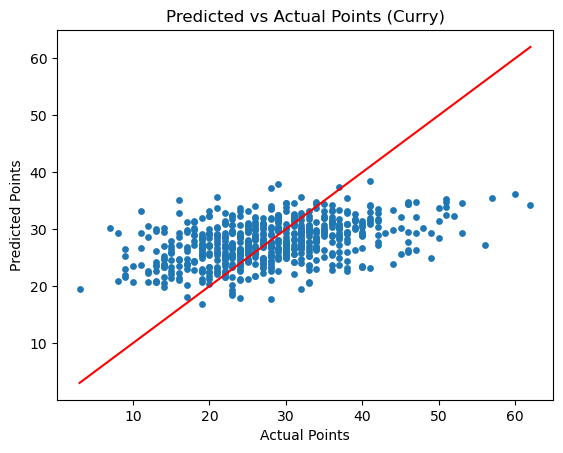

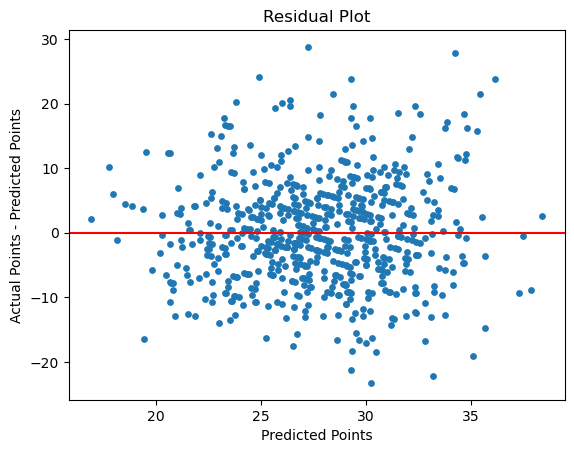

In [23]:
preds = cross_val_predict(best_model, X, y, cv=5)

plt.figure()
plt.scatter(y, preds, s=15)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red')
plt.xlabel("Actual Points")
plt.ylabel("Predicted Points")
plt.title("Predicted vs Actual Points (Curry)")

plt.figure()
plt.title('Residual Plot')
plt.xlabel('Predicted Points')
plt.ylabel('Actual Points - Predicted Points')
plt.scatter(preds, y-preds, s=15)
plt.axhline(y=0, color='r')
plt.show()

- Scatter Plot: Points are reasonably clustered around the reference line, meaning the model captures general scoring trends, though it tends to underpredict in some high-scoring games.

- Residual Plot: Residuals (actual - predicted) are scattered without a clear pattern, which is a good sign. It suggests the model isn’t systematically biased and errors are fairly random.

These plots confirm that while the model isn’t perfect, it's learned real signal from the data and isn’t overfitting.

## 📝 My Takeaway
This was a challenging yet rewarding project. This was the first ever one I've worked on, starting from the ground up. I spent months designing a realistic pipeline that predicts Stephen Curry’s next-game scoring without cheating by looking into future data. I learned how to:

- Access and manipulate NBA game data using the nba_api

- Engineer time-aware features like rolling averages and rest days

- Prevent data leakage and build a responsible, deployable dataset

- Tune a Ridge regression model using time-series cross-validation

- Interpret model behavior using coefficients and diagnostic plots

Even though the final model’s Mean Absolute Error (MAE) was 6.48, which isn't perfect, I now understand that model performance isn’t the only measure of success. What matters is that I:

- Built something from scratch

- Tackled real-world ML challenges (like leakage and seasonality)

- And learned how to communicate results honestly and clearly

If I revisit this project in the future, I’d like to:

- Explore tree-based models like XGBoost and RandomForestRegressor

- Integrate team-level defense metrics and pace

- Build an interactive web dashboard for predictions

Most importantly, this project showed me how much I have to learn, and the process I went through, including asking questions, failing, and adjusting.